# Drug Targeting different nodes of the 524 cascade system

## Init

In [3]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [4]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [5]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [ ]:
import os 

### parameters 

notebook_name = 'SISO_Drug_Model'
plot_figures = True
run_jobs = False
parallelise = True
save_figures = True

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 1500
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## Sample sizing parameters 
no_link_rm_range = (2,3)
no_sub_models = 1 
no_ml_runs = 1

## General parameters 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/SISO_Drug_Model_4_50/


## Jobs and Visualisations

### Generate drug network

In [7]:
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)

In [8]:
print(model_drug_spec.get_feedback_regulations())

[(('C', 'A1'), 'up'), (('B0', 'A2'), 'down')]


In [9]:
def modified_drug_spec_SY(original_spec: ModelSpecification): 
    spec = deepcopy(original_spec)
    added_regulations = [('C', 'A3'), ('B2', 'A4'), ('B1', 'A0'), ('B3', 'A2')]
    added_reg_types = ['down', 'down', 'up', 'up']
    for i, reg in enumerate(added_regulations):
        spec.add_regulation(reg, added_reg_types[i])
    return spec

In [10]:
modded_spec = modified_drug_spec_SY(model_drug_spec)
print(modded_spec.get_feedback_regulations())

[(('C', 'A1'), 'up'), (('B0', 'A2'), 'down'), (('C', 'A3'), 'down'), (('B2', 'A4'), 'down'), (('B1', 'A0'), 'up'), (('B3', 'A2'), 'up')]


In [11]:
# create a drug which targets all of the A species
drug_all_Ad = Drug('DAd', 500, 5000) 
drug_all_Ad.add_regulation('A0', 'down')
drug_all_Ad.add_regulation('A1', 'down')
drug_all_Ad.add_regulation('A2', 'down')
drug_all_Ad.add_regulation('A3', 'down')
drug_all_Ad.add_regulation('A4', 'down')

drug_all_Au = Drug('DAu', 500, 5000)
drug_all_Au.add_regulation('A0', 'up')
drug_all_Au.add_regulation('A1', 'up')
drug_all_Au.add_regulation('A2', 'up')
drug_all_Au.add_regulation('A3', 'up')
drug_all_Au.add_regulation('A4', 'up')

possible_drugs = [drug_all_Ad, drug_all_Au] 

In [12]:
diff_model_specs = []
diff_models = []
model_labels = []
for drug in possible_drugs:
    new_drug_spec = DrugModelSpecification()
    new_drug_spec.generate_specifications(4, 5, 2, verbose=0)
    new_drug_spec.add_drug(drug)
    new_model = new_drug_spec.generate_network(f'drug_model_524_{drug.name}', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
    new_model = copy_over_params_states(G0_d, new_model)
    label = f'{drug.name}'
    diff_model_specs.append(new_drug_spec)
    diff_models.append(new_model)
    model_labels.append(label)
    
    new_drug_spec = modified_drug_spec_SY(new_drug_spec)
    new_model = new_drug_spec.generate_network(f'drug_model_524_{drug.name}_SY', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
    new_model = copy_over_params_states(G0_d, new_model)
    label = f'{drug.name}SY'
    diff_model_specs.append(new_drug_spec)
    diff_models.append(new_model)
    model_labels.append(label)

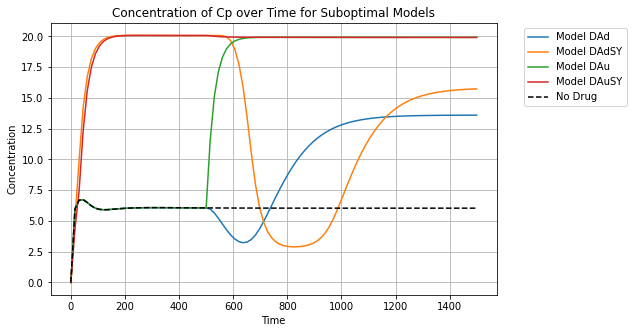

In [14]:
# perform simulations on each of the models 
import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(diff_models):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {model_labels[i]}")
        
    runner = roadrunner.RoadRunner(G0_d.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="No Drug", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Synthetic data for each model

In [ ]:
### Generate the synthetic data
feature_df_sets = []
initial_value_sets = []
target_df_sets = []
target_df_model_labels = []
time_course_data_sets = []

for i, model_spec in enumerate(diff_model_specs): 
    model = diff_models[i]
    runner = roadrunner.RoadRunner(model.get_sbml_model())
    feature_df = generate_feature_data(model_spec, runner, feature_generation_method, feature_generation_extra_params, feature_generation_size, seed=feature_generation_seed)
    initial_values = get_model_initial_values(model_spec, runner)
    target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values, simulation_params={'start': 0, 'end': simulation_time, 'points': simulation_step})
    feature_df_sets.append(feature_df)
    initial_value_sets.append(initial_values)
    target_df_sets.append(target_df)
    target_df_model_labels.append(model_labels[i])
    time_course_data_sets.append(time_course_data)

## Generate suboptimal models

In [ ]:
n_sub = no_sub_models
suboptimal_models_rms = []
suboptimal_models_spec_rms = []
suboptimal_models_labels = []
suboptimal_models_reg_deleted = []  # record the regulations that were deleted
n_edge_removed_range = no_link_rm_range

for i, model_spec in enumerate(diff_model_specs):
    model = diff_models[i]
    for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
        for j in range(n_sub):
            s_spec, s_model, reg_deleted = systematic_edge_pruning(model_spec, model, n_edge_removed, random_seed=j)
            suboptimal_models_spec_rms.append(s_spec)
            suboptimal_models_rms.append(s_model)
            suboptimal_models_labels.append(f'{model_labels[i]}_{n_edge_removed}_{j}')
            suboptimal_models_reg_deleted.append(reg_deleted)

In [14]:
if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(suboptimal_models_rms):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
        
    runner = roadrunner.RoadRunner(G0_d.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Generate timecourse data from ground truth and suboptimal models

In [16]:
time_course_data_sets = []
last_time_points_sets = []


ground_truth_timecourse_data = []
ground_truth_last_time_points = []
ground_truth_labels = []

all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
all_phos_species = [s+'p' for s in all_species]

for i, spec in enumerate(diff_model_specs):
    model = diff_models[i]
    runner = roadrunner.RoadRunner(model.get_sbml_model())
    time_course_data = generate_model_timecourse_data(spec, runner, feature_df, initial_values)
    last_time_points = last_time_point_method(time_course_data, all_phos_species)
    ground_truth_timecourse_data.append(time_course_data)
    ground_truth_last_time_points.append(last_time_points)
    ground_truth_labels.append(f'{model_labels[i]} Last Points G0')
    
print('Ground truth time course data generated, length:', len(ground_truth_timecourse_data))

if run_jobs: 
    all_species = model_spec.A_species + model_spec.B_species + model_spec.C_species
    all_phos_species = [s+'p' for s in all_species]
    for i, s_spec in enumerate(suboptimal_models_spec_rms):
        s_model = suboptimal_models_rms[i]
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        time_course_data = generate_model_timecourse_data(s_spec, runner, feature_df, initial_values)
        time_course_data_sets.append(time_course_data)
        last_time_points = last_time_point_method(time_course_data, all_phos_species)
        last_time_points_sets.append(last_time_points)
        
print('Suboptimal time course data generated, length:', len(time_course_data_sets))

Ground truth time course data generated, length: 4
Suboptimal time course data generated, length: 8


## Machine Learning

In [ ]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4, additional_payload=None):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return_payload = {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
    if additional_payload is not None:
        return_payload.update(additional_payload)
    return return_payload
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = ground_truth_last_time_points + last_time_points_sets
all_features_desc = ground_truth_labels + suboptimal_models_labels
deleted_edges_all = [None]*len(ground_truth_last_time_points) + suboptimal_models_reg_deleted
zipped_feature_data = list(zip(all_features, all_features_desc, deleted_edges_all))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = no_ml_runs
all_random_states = np.random.randint(0, 10000, n_random)

if run_jobs: 
    all_metric_data = []
    for i, target_data in enumerate(target_df_sets):
        metric_data = []
        if not parallelise:          
            counter = 0
            for (feature_data, feature_data_name, deleted_edges) in zipped_feature_data:
                # test only the feature data that is relevant to the target data
                if target_df_model_labels[i] in feature_data_name:
                    for (model, model_name) in zipped_model_data:
                        # print('Model:', model_name)
                        for rand in all_random_states:
                            metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand, additional_payload={'Deleted Edges': deleted_edges})
                            metric_data.append(metrics)
                            counter += 1 
                            print('completed', counter)
                        
        else:        
            # parallelise the model evaluation process using joblib
            from joblib import Parallel, delayed
            relevant_zipped_feature_data = [(feature_data, feature_data_name, deleted_edges) for (feature_data, feature_data_name, deleted_edges) in zipped_feature_data if target_df_model_labels[i] in feature_data_name]
            metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_df['Cp'], random_state=rand, additional_payload={'Deleted Edges': deleted_edges}) 
                                            for (feature_data, feature_data_name, deleted_edges) in relevant_zipped_feature_data
                                            for (model, model_name) in zipped_model_data
                                            for rand in all_random_states)
        
        metric_df = pd.DataFrame(metric_data)
        # create additional columns based on 'Feature Data' of the suboptimal model labels, e.g. edge removed, drug model used, suboptimal model rng seed 
        metric_df['Edge Removed'] = metric_df['Feature Data'].apply(lambda x: x.split('_')[1] if len(x.split('_')) > 1 else 'N/A')
        metric_df['Drug G0 Model'] = metric_df['Feature Data'].apply(lambda x: x.split('_')[0] if len(x.split('_')) > 1 else 'N/A')
        metric_df['Suboptimal Model Seed'] = metric_df['Feature Data'].apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 1 else 'N/A')
        metric_df['Target Label'] = target_df_model_labels[i]
        print(f'Completed evaluation for {target_df_model_labels[i]}, length of metric data:', len(metric_df))
        all_metric_data.append(metric_df)
    all_metric_df = pd.concat(all_metric_data)
    if save_figures:
        # to pickle 
        all_metric_df.to_pickle(experiment_folder + 'all_metric_df.pkl')
    

## Visualising Dataset

In [17]:
# load the metric data from the pickle file
metric_df = pd.read_pickle(experiment_folder + 'metric_df.pkl')

In [18]:
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,Edge Removed,Drug G0 Model,Suboptimal Model Seed
0,Linear Regression,Mock Omics Data (A+B),2.537075,0.852445,0.925190,2.961253e-85,N/A,N/A,N/A
1,Linear Regression,Mock Omics Data (A+B),2.705325,0.876028,0.939084,8.716734e-94,N/A,N/A,N/A
2,Linear Regression,Mock Omics Data (A+B),2.142872,0.861232,0.929026,1.959752e-87,N/A,N/A,N/A
3,Linear Regression,Mock Omics Data (A+B),2.316260,0.854865,0.925805,1.349475e-85,N/A,N/A,N/A
4,Linear Regression,Mock Omics Data (A+B),2.430442,0.864928,0.930136,4.347593e-88,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...,...
18245,Neural Network,DAuSY_10_9,0.751725,0.960445,0.980157,3.955756e-141,10,DAuSY,9
18246,Neural Network,DAuSY_10_9,0.962220,0.950551,0.975088,1.865021e-131,10,DAuSY,9
18247,Neural Network,DAuSY_10_9,0.541392,0.971671,0.986010,4.956049e-156,10,DAuSY,9
18248,Neural Network,DAuSY_10_9,0.785171,0.960587,0.980206,3.113381e-141,10,DAuSY,9


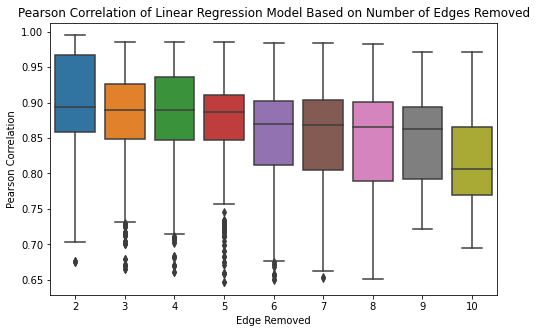

In [21]:
edge_removed_metric_df = metric_df[metric_df['Edge Removed'] != 'N/A']
lin_reg_edge_removed_metric_df = edge_removed_metric_df[edge_removed_metric_df['Model'] == 'Linear Regression']

# plot the performance of the linear regression model based on the number of edges removed
plt.figure(figsize=(8, 5))
sns.boxplot(x='Edge Removed', y='Pearson Correlation', data=lin_reg_edge_removed_metric_df)
plt.title('Pearson Correlation of Linear Regression Model Based on Number of Edges Removed')
plt.show()

In [23]:
# print all the unique values of the 'Edge Removed' column and 'Drug G0 Model' and 'Suboptimal Model Seed'
print('Unique Values of Edge Removed:', edge_removed_metric_df['Edge Removed'].unique())
print('Unique Values of Drug G0 Model:', edge_removed_metric_df['Drug G0 Model'].unique())
print('Unique Values of Suboptimal Model Seed:', edge_removed_metric_df['Suboptimal Model Seed'].unique())
print('Unique Values of Model:', edge_removed_metric_df['Model'].unique())

Unique Values of Edge Removed: ['2' '3' '4' '5' '6' '7' '8' '9' '10']
Unique Values of Drug G0 Model: ['DAd' 'DAdSY' 'DAu' 'DAuSY']
Unique Values of Suboptimal Model Seed: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Unique Values of Model: ['Linear Regression' 'Random Forest' 'Gradient Boosting'
 'Support Vector Machine' 'Neural Network']


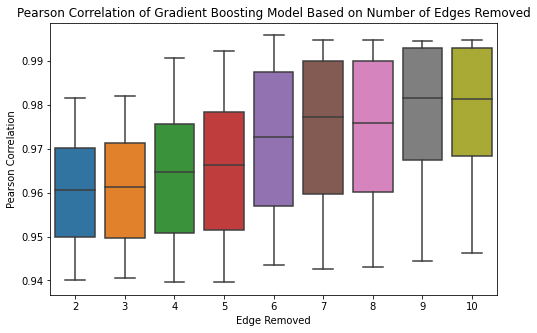

In [ ]:
edge_removed_metric_df = metric_df[metric_df['Edge Removed'] != 'N/A']
lin_reg_edge_removed_metric_df = edge_removed_metric_df[edge_removed_metric_df['Model'] == 'Gradient Boosting']
lin_reg_edge_removed_metric_df_s2 = lin_reg_edge_removed_metric_df[lin_reg_edge_removed_metric_df['Suboptimal Model Seed'] == '5']
dmodel_df = lin_reg_edge_removed_metric_df[lin_reg_edge_removed_metric_df['Drug G0 Model'] == 'DAd']

# plot the performance of the linear regression model based on the number of edges removed
plt.figure(figsize=(8, 5))
sns.boxplot(x='Edge Removed', y='Pearson Correlation', data=dmodel_df)
plt.title('Pearson Correlation of Gradient Boosting Model Based on Number of Edges Removed')
plt.show()